In [2]:
%matplotlib inline

In [3]:
import mne
import pathlib
import matplotlib.pyplot as plt

plt.style.use("minimal.mplstyle")
mne.viz.set_browser_backend("matplotlib")

Using matplotlib as 2D backend.


In [4]:
RAW_DATA_PATH = pathlib.Path("../data/EEG")

SESSION = "group13_own"

In [5]:
raw = mne.io.read_raw_brainvision(
    vhdr_fname = RAW_DATA_PATH.joinpath(SESSION + ".vhdr"),
    eog = ("HEOG", "VEOG"),
    misc = ("41",),
    preload = True,
    verbose = False
)

raw.set_montage(
    mne.channels.make_standard_montage("standard_1020"), 
    verbose=False
)

raw.info

C:\Users\dl\AppData\Local\Temp\ipykernel_47632\4173104079.py:1: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(


Measurement date,"February 28, 2024 14:02:50 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,33 points
Good channels,"30 EEG, 2 EOG, 1 misc"
Bad channels,None
EOG channels,"HEOG, VEOG"
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.00 Hz
Lowpass,1000.00 Hz


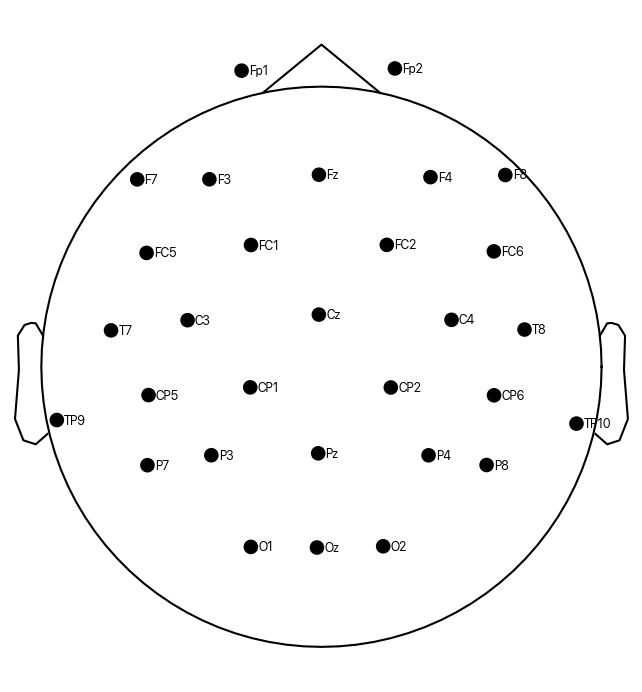

In [6]:
raw.plot_sensors(show_names = True);

Effective window size : 2.048 (s)


c:\Users\dl\AppData\Local\Programs\Python\Python310\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


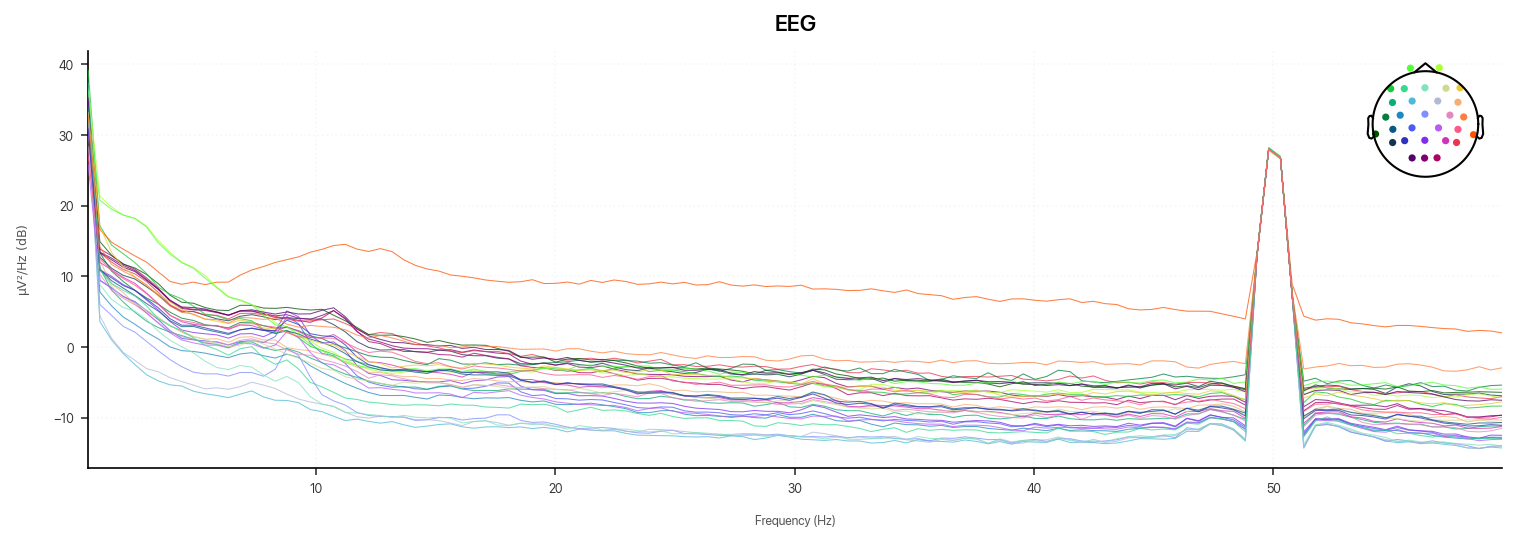

In [7]:
raw.compute_psd(
    fmin=0.01, 
    fmax=60,
    remove_dc=False
).plot();

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


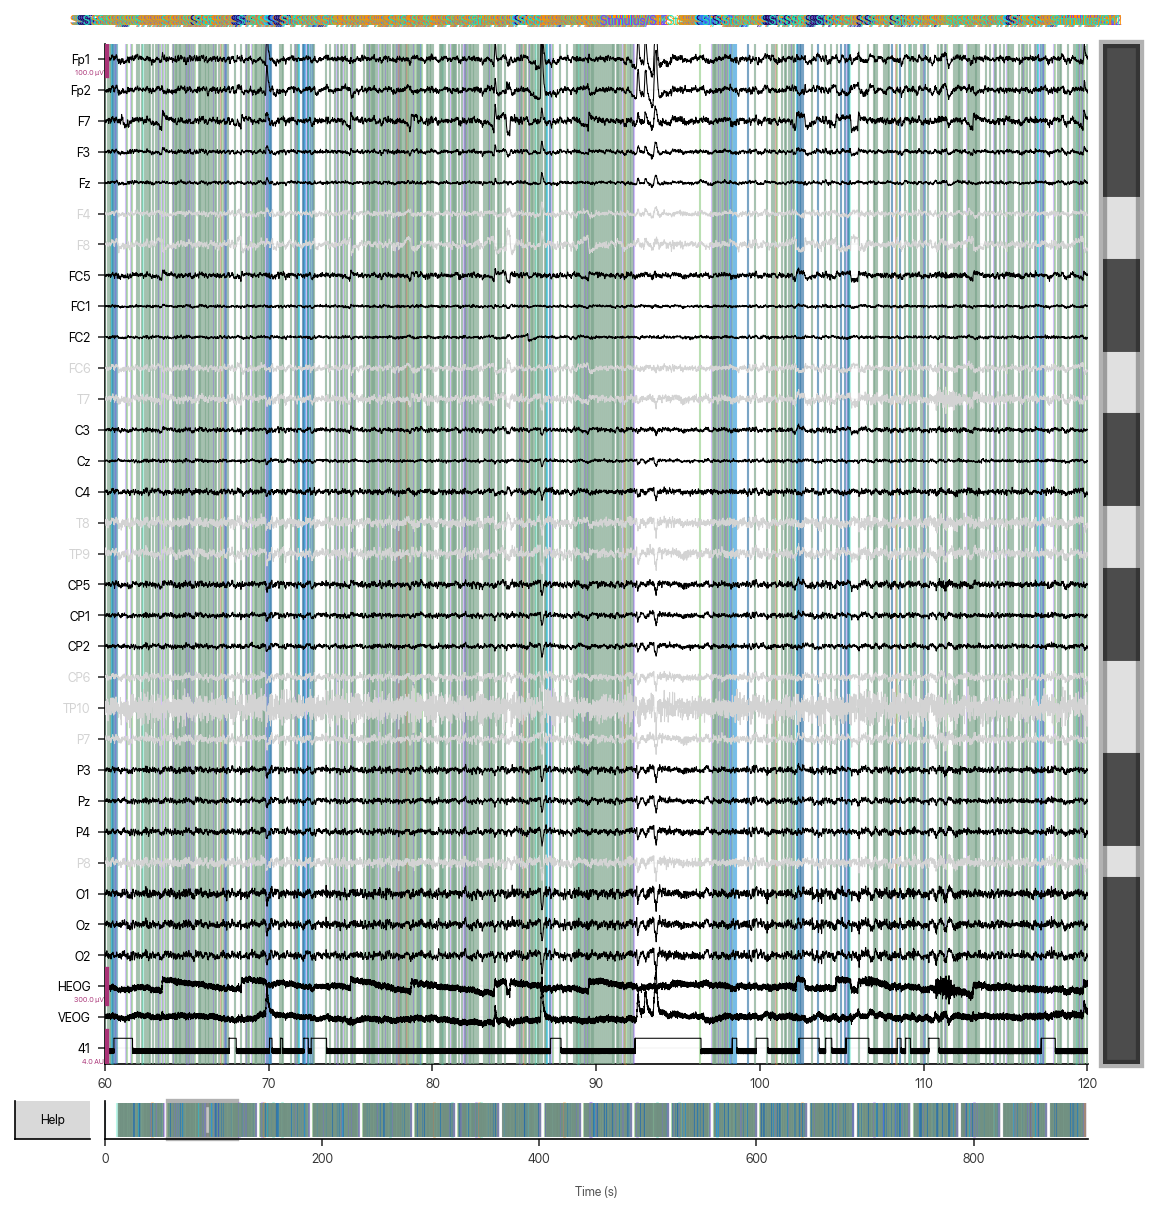

In [8]:
raw.filter(
    l_freq = 1, # pass everything over _ Hz
    h_freq = 40, # pass everything below _ Hz
)

plot_settings = dict(
    events = None,
    n_channels=len(raw.ch_names),
    scalings=dict(
        eeg = 5e-5,
        misc = 2
    ),
    start = 60,
    duration = 60,
    precompute = True,
    block = False,
    use_opengl = True
)

raw.info["bads"] = [
    "CP6",
    "F4",
    "FC6",
    "F8",
    "T7",
    "T8",
    "TP9",
    "TP10",
    "P7",
    "P8"
]

raw.pick(
    picks=raw.ch_names, 
    exclude="bads"
)

raw.plot(**plot_settings);

In [9]:
raw.set_eeg_reference(
    "average", 
    projection=False, 
    verbose=False
)

Measurement date,"February 28, 2024 14:02:50 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,33 points
Good channels,"20 EEG, 2 EOG, 1 misc"
Bad channels,"CP6, F4, FC6, F8, T7, T8, TP9, TP10, P7, P8"
EOG channels,"HEOG, VEOG"
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14']


C:\Users\dl\AppData\Local\Temp\ipykernel_47632\278249608.py:14: RuntimeWarning: Color was not assigned for events 1, 2, 11, 12, 13, 14, 99999. Default colors will be used.
  mne.viz.plot_events(


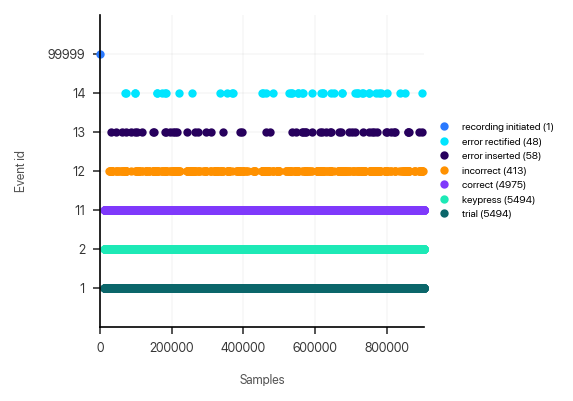

In [10]:
EVENT_ENCODINGS = {
    "trial"               : 1,
    "keypress"            : 2,
    "correct"             : 11,
    "incorrect"           : 12,
    "error inserted"      : 13,
    "error rectified"     : 14,
    "recording initiated" : 99999 
}

events, event_ids = mne.events_from_annotations(raw)

mne.viz.plot_events(
    events, 
    event_id = EVENT_ENCODINGS,
    color = dict(),
    on_missing = "ignore",
    show = True
);

In [11]:
epochs = mne.Epochs(
    raw, 
    events,
    event_id = EVENT_ENCODINGS, 
    reject = dict(eeg = 150e-6), 
    tmin = -0.2, 
    tmax = 0.8,
    baseline = (-0.2, 0),
    preload = True,
    verbose = False
)
epochs.info

Measurement date,"February 28, 2024 14:02:50 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,33 points
Good channels,"20 EEG, 2 EOG, 1 misc"
Bad channels,"CP6, F4, FC6, F8, T7, T8, TP9, TP10, P7, P8"
EOG channels,"HEOG, VEOG"
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [12]:
print(f"{len([ep for ep in epochs.drop_log if len(ep)]) / len(events):.1%} of epochs were dropped")

7.5% of epochs were dropped


In [13]:
epochs.resample(sfreq=250)

Number of events,15244
Events,correct: 4595error inserted: 56error rectified: 44incorrect: 389keypress: 5076recording initiated: 0trial: 5084
Time range,-0.200 – 0.796 s
Baseline,-0.200 – 0.000 s


Not setting metadata
4639 matching events found
No baseline correction applied
0 projection items activated


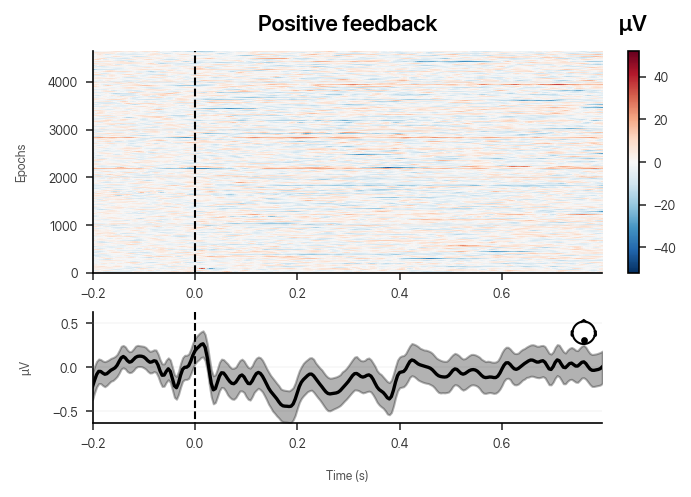

Not setting metadata
445 matching events found
No baseline correction applied
0 projection items activated


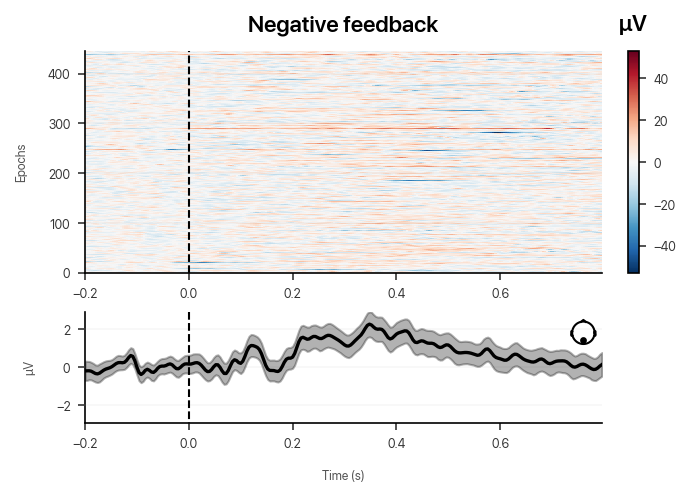

In [26]:
for condition, events in zip(("Positive feedback", "Negative feedback"), [["correct", "error rectified"], ["incorrect", "error inserted"]]):
    epochs[events].plot_image(
        picks = ["Oz"],
        title = condition,
    )[0];

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


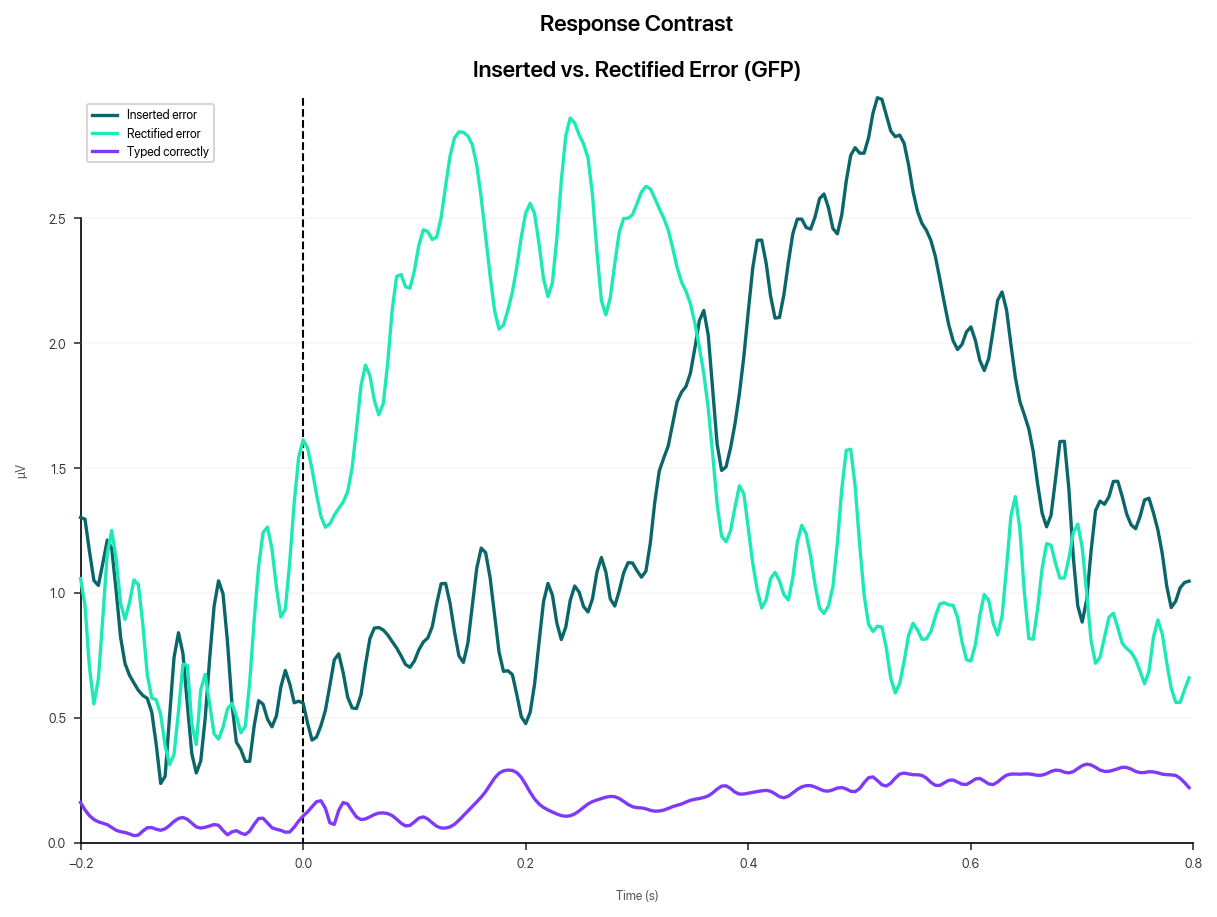

In [15]:
mne.viz.plot_compare_evokeds(
    evokeds={
        "Inserted error"    : epochs["error inserted"].average(),
        "Rectified error"   : epochs["error rectified"].average(),
        "Typed correctly"   : epochs["correct"].average(),
    }, 
    ci = 0.95,
    title = "Response Contrast\n\nInserted vs. Rectified Error"
)[0];